# Monte Carlo simulation for estimating slope failure risk

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">

This notebook is an element of the free [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to use of Python and the [NumPy library](https://www.numpy.org/) for Monte Carlo simulation applied to the estimation of the stability of natural slopes (basic predictions of **landslide risk**). See the [associated course materials](https://risk-engineering.org/monte-carlo-methods/) for background on stochastic simulation methods and to download this content as a Jupyter/Python notebook.

**Acknowledgement**. This notebook is an adaptation of an exercise from the [MIT course “Probability and statistics in engineering”](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-151-probability-and-statistics-in-engineering-spring-2005/lecture-notes/) taught by Prof. Daniele Veneziano (application example 17). 

## Predicting landslide risk

The possible instability of natural slopes is a major geological hazard in many hilly or mountainous regions of the world. It can lead to landslides that sweep away houses and vehicles, and at a smaller scale the collapse of embankments along railway lines can lead to derailments, or to dike failures and flooding. The degree of stability of a slope may be expressed through the slope stability factor $F$, which is the ratio between a soil resistance measure and the associated applied load. Hence values of $F$ larger than 1 are associated with stability and values smaller than 1 indicate unstable conditions. For natural slopes with a shallow soil layer, the slope stability factor is given by (Skempton and DeLory, 1957):

$F = \frac{c}{\gamma z \sin(\alpha) \cos(\alpha)} + \frac{\tan(\phi)}{\tan(\alpha)} - m \frac{\gamma_w \tan(\phi)}{\gamma \tan(\alpha)}$

where:

- $c$ is the cohesion of the soil
- $\phi$ is the angle of internal friction of the soil
- $\gamma$ is the unit weight of the soil
- $\gamma_w$ is the unit weight of water
- $\alpha$ is the inclination of the slope to the horizontal, larger than 0
- $z$ is the depth below the ground surface
- $z_w$ is the depth of the water table below the ground surface
- $m$ is the degree of saturation of the soil, where $m = \frac{z_w - z}{z}$

This is called the *infinite slope stability model*.

The failure criterion is $F < 1$. Areas with $1 < F < 1.25$ are said to be moderately susceptible to landslide risk, with $1.25 < F < 1.5$ slightly susceptible and not susceptible (or stable) for $F > 1.5$. 

With the following typical values for the parameters, we have $F = 1.15$, meaning the slope is moderately susceptible.

In [1]:
import math
from typing import NamedTuple

# here we use some modern Python features that help detect typos
class Params(NamedTuple):
    z: float
    z_w: float
    m: float
    c: float
    phi: float
    alpha: float
    gamma: float
    gamma_w: float

def default_params() -> Params:
    return Params(z=5, 
        z_w = 2.5,
        m = 0.5,
        c = 25,
        phi = math.radians(30),
        alpha = math.radians(35),
        gamma = 20,
        gamma_w = 9.81)

def slope_stability(p: Params):
    c1 = p.c / (p.gamma * p.z * math.sin(p.alpha) * math.cos(p.alpha))
    c2 = math.tan(p.phi) / math.tan(p.alpha)
    c3 = p.m * p.gamma_w * math.tan(p.phi) / (p.gamma * math.tan(p.alpha))
    return c1 + c2 - c3

slope_stability(default_params())

1.1544116861109888

To check our intuitive understanding of landslide risk, let’s check that risk increases ($F$ goes down) as the slope increases between 0 and 90° (maintaining all other inputs at their central values), and also that the risk increases as the amount of water in the soil increases. 

In [2]:
import numpy
import matplotlib.pyplot as plt
plt.style.use("bmh")

def slope_stability_alpha(alpha: float) -> float:
    params = default_params()
    return slope_stability(params._replace(alpha=math.radians(alpha)))

support = numpy.linspace(1, 45, 100)
outputs = numpy.array([slope_stability_alpha(a) for a in support])


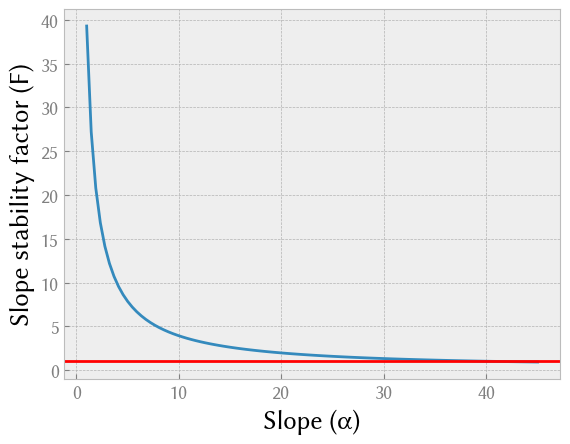

In [3]:
plt.plot(support, outputs)
plt.axhline(y=1, color="r")
plt.xlabel("Slope (α)")
plt.ylabel("Slope stability factor (F)");

In [4]:
def slope_stability_m(m: float) -> float:
    params = default_params()
    return slope_stability(params._replace(m=m))

support = numpy.linspace(0.05, 0.95, 100)
outputs = numpy.array([slope_stability_m(m) for m in support])

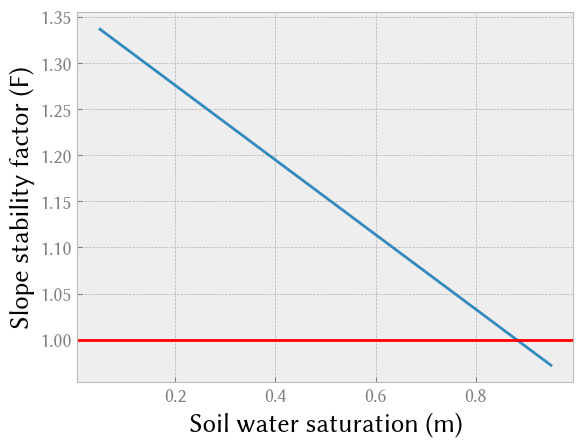

In [5]:
plt.plot(support, outputs)
plt.axhline(y=1, color="r")
plt.xlabel("Soil water saturation (m)")
plt.ylabel("Slope stability factor (F)");

## Uncertainty analysis

The main uncertain parameters are $c$ and $\phi$, with coefficients of variation respectively of 0.2 and 0.25. Experience shows that they can be assumed to be normally distributed. To run a stochastic simulation, we define a function that generates one random set of inputs to the stability calculation.

In [6]:
import scipy.stats

# CV = sigma / mu 
def randomize_params(params: Params):
    return params._replace(c=scipy.stats.norm(25, 0.2*25).rvs(),
                          phi=scipy.stats.norm(math.radians(30), 0.25*math.radians(30)).rvs())

randomize_params(default_params())

Params(z=5, z_w=2.5, m=0.5, c=22.706745693654625, phi=0.7691946065729907, alpha=0.6108652381980153, gamma=20, gamma_w=9.81)

We can now run a Monte Carlo simulation to estimate the distribution of the safety factor $F$.

In [7]:
import numpy

N = 10_000
sim = numpy.zeros(N)
failed = 0
for i in range(N):
    sim[i] = slope_stability(randomize_params(default_params()))
    if sim[i] < 1:
        failed += 1
print("Estimated failure probability: {:.3f}".format(failed / float(N)))

Estimated failure probability: 0.225


Recall that simulations with a slope stability factor less than 1 (to the left of the red line in the histogram below) represent failures (landslides).

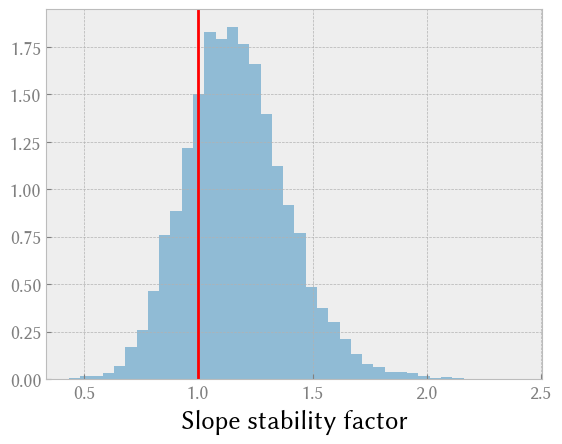

In [8]:
plt.hist(sim, bins=40, density=True, alpha=0.5)
plt.axvline(x=1, color="r")
plt.xlabel("Slope stability factor");

We can estimate the failure probability as a function of the slope.

In [9]:
def failure_probability_alpha(alpha: float) -> float:
    N = 1000
    failed = 0
    for i in range(N):
        params = randomize_params(default_params())
        params = params._replace(alpha=math.radians(alpha))
        if slope_stability(params) < 1:
            failed += 1
    return failed / float(N)

support = numpy.linspace(1, 55, 20)
outputs = numpy.array([failure_probability_alpha(a) for a in support])

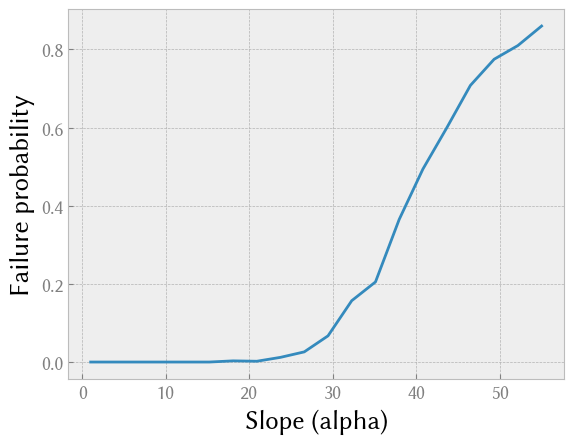

In [10]:
plt.plot(support, outputs)
plt.xlabel("Slope (alpha)")
plt.ylabel("Failure probability");

Similarly, we can plot failure probability as a function of the soil’s water saturation.

In [11]:
def failure_probability_m(m: float) -> float:
    N = 1000
    failed = 0
    for i in range(N):
        params = randomize_params(default_params())
        if slope_stability(params._replace(m=m)) < 1:
            failed += 1
    return failed / float(N)

support = numpy.linspace(0.05, 0.95, 20)
outputs = numpy.array([failure_probability_m(m) for m in support])

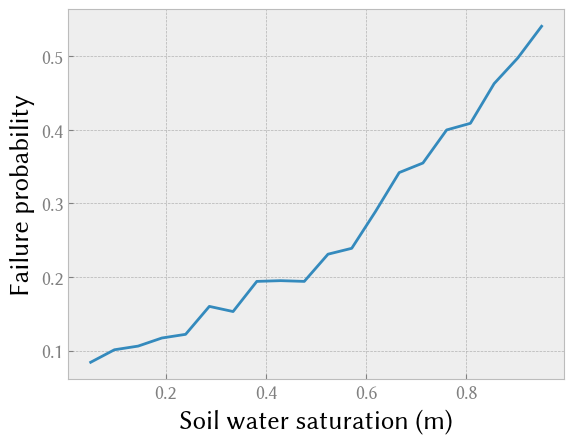

In [12]:
plt.plot(support, outputs)
plt.xlabel("Soil water saturation (m)")
plt.ylabel("Failure probability");